In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

In [2]:
# Unfortunately this URL doesn't work directly with pd.read_csv
# !wget -nc https://lazyprogrammer.me/course_files/spam.csv

In [3]:
path = 'D:\\Sandbox\\GitHub\\data\\spam.csv'
# path = tf.keras.utils.get_file('spam.csv', 'https://lazyprogrammer.me/course_files/spam.csv')
print (path)

D:\Sandbox\GitHub\data\spam.csv


In [4]:
df = pd.read_csv(path, encoding='ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# rename columns to something better
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [9]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [10]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7147 unique tokens.


In [11]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3733, 162)


In [12]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 162)


In [13]:
reverse_word_index = dict([(value, key) for (key, value) in word2idx.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(data_train[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0  198   15   92   38 2301  183    4
  885  519  495  815  151   18 1244  974  816   41    9    5  471  571
    2  403    3   16 1755  817 1756  385]


In [14]:
print(decode_review(data_train[0]))

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? lmao you know me so well


In [15]:
df_train.head(5)

5052                          Lmao you know me so well...
2206    URGENT! Your mobile No 07xxxxxxxxx won a å£2,0...
2039    Dont pack what you can buy at any store.like c...
580     Huh so early.. Then Ì_ having dinner outside i...
584     So how's scotland. Hope you are not over showi...
Name: data, dtype: object

In [16]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [17]:
# Compile and fit
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [18]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 162)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 162, 20)           142960    
_________________________________________________________________
conv1d (Conv1D)              (None, 160, 32)           1952      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 53, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 51, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 17, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 128)          

In [19]:
history = model.fit(
  data_train,
  Ytrain,
  epochs=5,
  validation_data=(data_test, Ytest)
)

Epoch 1/5
117/117 [==============================] - 2s 16ms/step - loss: 0.3718 - accuracy: 0.8711 - val_loss: 0.3005 - val_accuracy: 0.8554
Epoch 2/5
117/117 [==============================] - 2s 15ms/step - loss: 0.1690 - accuracy: 0.9255 - val_loss: 0.1442 - val_accuracy: 0.9581
Epoch 3/5
117/117 [==============================] - 2s 17ms/step - loss: 0.0359 - accuracy: 0.9871 - val_loss: 0.1025 - val_accuracy: 0.9739
Epoch 4/5
117/117 [==============================] - 2s 14ms/step - loss: 0.0095 - accuracy: 0.9979 - val_loss: 0.0959 - val_accuracy: 0.9777
Epoch 5/5
117/117 [==============================] - 2s 15ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.0809 - val_accuracy: 0.9782


In [20]:
print(model.metrics_names)

['loss', 'accuracy']


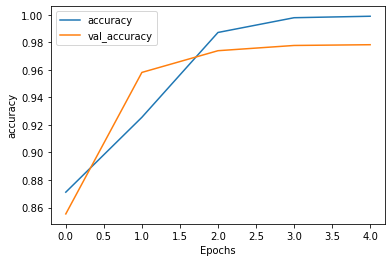

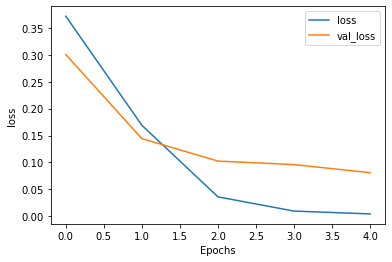

In [21]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [23]:
from sklearn.metrics import classification_report,confusion_matrix
y_prediction = np.argmax(model.predict(data_test), axis=-1)
print(classification_report(Ytest,y_prediction))
print(confusion_matrix(Ytest,y_prediction))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1573
           1       0.00      0.00      0.00       266

    accuracy                           0.86      1839
   macro avg       0.43      0.50      0.46      1839
weighted avg       0.73      0.86      0.79      1839

[[1573    0]
 [ 266    0]]


In [27]:
# Show some misclassified examples
misclassified_idx = np.where(y_prediction != Ytest)[0]
i = np.random.choice(misclassified_idx)
print(decode_review(data_test[i]))
print("Spam label: %s but predicted: %s" % (Ytest[i], y_prediction[i]))

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? call germany for only 1 pence per minute call from a fixed line via access number 0844 861 85 85 no prepayment direct access
Spam label: 1 but predicted: 0


In [26]:
# Predicting Sentiment in New Reviews Use the model to predict a review   
fake_reviews = ['I love this phone', 'I hate spaghetti', 
                'Everything was cold',
                'Everything was hot exactly as I wanted', 
                'Everything was green', 
                'the host seated us immediately',
                'they gave us free chocolate cake', 
                'not sure about the wilted flowers on the table',
                'only works when I stand on tippy toes',
                'bats are all wearing underwears with tie',
                'bat was runnig the show',
                'does not work when I stand on my head']

print(fake_reviews) 

# Create the sequences

sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
fakes_padded = pad_sequences(sample_sequences, maxlen = T)           

print('\nHERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE SPAMS!\n')              

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
for x in range(len(fake_reviews)):
  print(fake_reviews[x])
  np.argmax(print(classes[x]))
  print('\n')

# Try adding reviews of your own
# Add some negative words (such as "not") to the good reviews and see what happens
# For example:
# they gave us free chocolate cake and did not charge us

['I love this phone', 'I hate spaghetti', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'the host seated us immediately', 'they gave us free chocolate cake', 'not sure about the wilted flowers on the table', 'only works when I stand on tippy toes', 'bats are all wearing underwears with tie', 'bat was runnig the show', 'does not work when I stand on my head']

HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE SPAMS!

I love this phone
[1.736159e-05]


I hate spaghetti
[0.01336521]


Everything was cold
[0.00167954]


Everything was hot exactly as I wanted
[0.00083843]


Everything was green
[0.00167954]


the host seated us immediately
[0.01305917]


they gave us free chocolate cake
[0.00249958]


not sure about the wilted flowers on the table
[0.00041145]


only works when I stand on tippy toes
[1.2837405e-05]


bats are all wearing underwears with tie
[0.01605946]


bat was runnig the show
[0.00030926]


does not work when I stand on my head
[7.